# 3D Batch Generator

In [1]:
import numpy as np
import pandas as pd
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input, Lambda, Conv2D
from keras.preprocessing import image
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json, Sequential
from keras.utils import Sequence
from keras.layers import Flatten, BatchNormalization, Activation, MaxPool2D, Dropout
import math
import keras
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense
from keras.layers import Flatten, BatchNormalization, Activation, MaxPool2D
from keras.layers import Conv3D, MaxPool3D, SpatialDropout3D
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
from tqdm import tqdm

## Metadata vs Lane
    * Metadata is the full dataset annotations
    * Lane is referres to the 'clean' version
    
    Note: The filenames column have the whole path to the image :)
    
    The data is sampled at 20Hz


In [3]:
# Open all 
lane1 = pd.read_csv('Dataset/2016-01-30--11-24-51/Metadata/lane_df.csv',index_col=0)

#lane2 = pd.read_csv('Dataset/2016-01-30--13-46-00/Metadata/lane_df.csv',index_col=0)

#lane3 = pd.read_csv('Dataset/2016-01-31--19-19-25/Metadata/lane_df.csv',index_col=0)

lane4 = pd.read_csv('Dataset/2016-02-02--10-16-58/Metadata/lane_df.csv',index_col=0)

lane5 = pd.read_csv('Dataset/2016-02-08--14-56-28/Metadata/lane_df.csv',index_col=0)

lane6 = pd.read_csv('Dataset/2016-02-11--21-32-47/Metadata/lane_df.csv',index_col=0)

lane7 = pd.read_csv('Dataset/2016-03-29--10-50-20/Metadata/metadata.csv',index_col=0)

#lane8 = pd.read_csv('Dataset/2016-03-29--10-50-20/Metadata/metadata.csv',index_col=0)

#lane9 = pd.read_csv('Dataset/2016-04-21--14-48-08/Metadata/metadata.csv',index_col=0)

#lane10 = pd.read_csv('Dataset/2016-05-12--22-20-00/Metadata/metadata.csv',index_col=0)

#lane11 = pd.read_csv('Dataset/2016-06-02--21-39-29/Metadata/metadata.csv',index_col=0)

#test = pd.read_csv('Dataset/2016-06-08--11-46-01/Metadata/metadata.csv',index_col=0)


In [4]:
X = []
Y = []
for df in [lane1, lane5, lane6, lane7]:#, lane8, lane9, lane10]:
    X.append(df['filenames'].values)
    Y.append(df['steering_angle'].values)

X = np.concatenate(X)
Y = np.concatenate(Y).astype('float32')

# Subsample at 10 Hz
X = X[::4]
Y = Y[::4]

print('Shape X', np.shape(X))
print('Shape Y', np.shape(Y))

Shape X (46527,)
Shape Y (46527,)


## Opening images using the lane reference

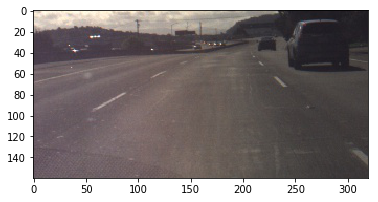

In [5]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

filename = lane1['filenames'].iloc[0]
img = np.array(image.load_img(filename))
plt.imshow(img)

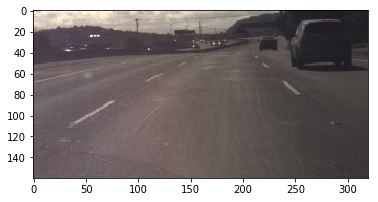

In [6]:
from PIL import Image
filename = lane1['filenames'].iloc[2]
img = Image.open(filename)
plt.imshow(img)

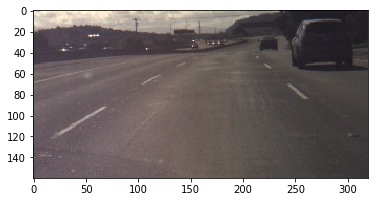

In [11]:
from PIL import Image
filename = lane1['filenames'].iloc[3]
img = Image.open(filename)
plt.imshow(img)

In [15]:
np.shape(imgarr)

(160, 320, 3)

## VGG-like Normalisation 

In [9]:
# Extract Red, Green and Blue channels
red = [ x[:,:,0] for x in im_X[:20000]]
green = [ x[:,:,1] for x in im_X[:20000]]
blue = [ x[:,:,2] for x in im_X[:20000]]


#red = []
#for x in im_X:
#    red.append(x[:,:,0])
    
#green = []
#for x in im_X:
#    red.append(x[:,:,1])    
    
#blue = []
#for x in im_X:
#    red.append(x[:,:,2])    
    
    
# [0, 1] Normalisation
red = np.array(red)/255
green = np.array(green)/255
blue = np.array(blue)/255

# Compute mean and STD
red_mean = np.mean(red)
green_mean = np.mean(green)
blue_mean = np.mean(blue)

red_std = np.std(red)
green_std = np.std(green)
blue_std = np.std(blue)

print('Mean channel 1 = ', red_mean)
print('Mean channel 2 = ', green_mean)
print('Mean channel 3 = ', blue_mean)

print('Std channel 1 = ', red_std)
print('Std channel 2 = ', green_std)
print('Std channel 3 = ', blue_std)

Mean channel 1 =  0.26050034225643537
Mean channel 2 =  0.2312083639131408
Mean channel 3 =  0.24843249347809407
Std channel 1 =  0.13651061907666232
Std channel 2 =  0.12975487270224326
Std channel 3 =  0.11177383998081789


In [7]:
# Final values
mean = [0.283, 0.256, 0.264 ]
std = [0.134, 0.120, 0.105 ]

def normalize(img, mean=[0.26, 0.221, 0.248 ], std=[0.136, 0.129, 0.111]):
    '''Normalize image and returns RGB format.
    '''
    img = img/255
    red = (img[:,:,0] - mean[0]) / std[0]
    green = (img[:,:,1] - mean[1]) / std[1]
    blue = (img[:,:,2] - mean[2]) / std[2]

    return np.dstack((red,green,blue))

def norm2(img):
    return (img / 255) - 0.5
#im = train_X[1110]

#plt.imshow(normalize(im))

## Batch Generator

In [9]:
from keras.utils import Sequence
class Batch_generator(Sequence):
    '''Generates batches of images and labels on the fly from disc. 
    Uses process_line() function to perform image reading transformation.
    x_set: Numpy array with filenames (strings)
    y_set: Numpy array with binary gender labels (0,1)
    batch_size: Number of samples per batch
    '''
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
            self.batch_size]

        x = np.array([process_line(depth_filename) for depth_filename in batch_x]), batch_y.astype('float32') 
        
        return x

    
def process_line(filenames):
    '''Process one line of the batch directory.------------------------
    Enters an array of 16 filenames
     # Open image from lfw/ folder. Convert it to Numpy array    
    '''
    pack = []
    for name in np.flipud(filenames):
        pack.append(norm2(np.array(image.load_img(name)).astype('float32')))
        #img = Image.open(filename)
        #pack.append(normalize(np.array(Image.open(name))))   

    return np.array(pack)


In [31]:
for name in np.flipud(new_X[0]):
    print(name)

Dataset/2016-01-30--11-24-51/Images/22700.jpg
Dataset/2016-01-30--11-24-51/Images/22690.jpg
Dataset/2016-01-30--11-24-51/Images/22680.jpg
Dataset/2016-01-30--11-24-51/Images/22670.jpg
Dataset/2016-01-30--11-24-51/Images/22660.jpg
Dataset/2016-01-30--11-24-51/Images/22650.jpg
Dataset/2016-01-30--11-24-51/Images/22640.jpg
Dataset/2016-01-30--11-24-51/Images/22630.jpg
Dataset/2016-01-30--11-24-51/Images/22620.jpg
Dataset/2016-01-30--11-24-51/Images/22610.jpg
Dataset/2016-01-30--11-24-51/Images/22600.jpg
Dataset/2016-01-30--11-24-51/Images/22590.jpg
Dataset/2016-01-30--11-24-51/Images/22580.jpg
Dataset/2016-01-30--11-24-51/Images/22570.jpg
Dataset/2016-01-30--11-24-51/Images/22560.jpg
Dataset/2016-01-30--11-24-51/Images/22550.jpg


# Generate filenames in packs of 16

In [32]:
new_X = []
new_Y = []
# tensor size = 16
# Overlap = 6
for i in range(int(X.shape[0]/10)):
    if int(i*10+16) < int(X.shape[0]):
        new_X.append(X[i*10:i*10+16])
        new_Y.append(Y[i*10+16])
    else:
        break
    
new_X = np.array(new_X)
new_Y = np.array(new_Y)

## Formal Function

In [10]:
def generate_index(X, Y, tensor_size=6, overlap=3):
    step = tensor_size-overlap
    new_X = []
    new_Y = []
    for i in range(int(X.shape[0]/step)):
        if int(i*step+tensor_size) < int(X.shape[0]):
            new_X.append(X[i*step:i*step+tensor_size])
            new_Y.append(Y[i*step+tensor_size])
        else:
            break
    return np.array(new_X), np.array(new_Y)


In [11]:
new_X, new_Y = generate_index(X, Y)
print('new_X size', new_X.shape)
print('new_Y size', new_Y.shape)

new_X size (15507, 6)
new_Y size (15507,)


In [39]:
pack = []
for i in range(15):
    pack.append(process_line(new_X[i]))

np.shape(pack)

(15, 16, 160, 320, 3)

In [12]:
#def Model3D(input_shape = (320,160,15,3)):
def Model3D(input_shape = (6,160,320,3)):
    '''Pixel3D conv allows to make 100M parameters economy'''

    inputs = Input(input_shape)
    #x = BatchNormalization()(inputs)
    # Conv1a
    x = Conv3D(64,(3, 3, 3),strides=(1,1,1),padding='same',
                activation='relu')(inputs)
    #x = BatchNormalization()(x)
    x = MaxPool3D((2,2,1),strides=(2,2,1),padding='same')(x)

    # Conv 2a
    x = Conv3D(128,(3, 3, 3),strides=(1,1,1),padding='same',
               activation='relu')(x)
    #x = BatchNormalization()(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)
    #x = BatchNormalization()(x)

    # Conv3a and 3b
    x = Conv3D(256,(3, 3, 3),strides=(1,1,1),padding='same',
               activation='relu')(x)
    #x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(256,(3, 3, 3),strides=(1,1,1),padding='same',
               activation='relu')(x)
    
    #x = BatchNormalization()(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)
    #x = BatchNormalization()(x)


    # Conv4a and 4b
    x = Conv3D(512,(3, 3, 3),strides=(1,1,1),padding='same',
               activation='relu')(x)
    #x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(512,(3, 3, 3),strides=(1,1,1),padding='same',
               activation='relu')(x)
    
    #x = BatchNormalization()(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)
    #x = BatchNormalization()(x)


    # Conv 5a and 5b
    x = Conv3D(512, (3, 3, 3), strides=(1, 1, 1), padding='same',
               activation='relu')(x)

    x = Conv3D(512,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu')(x)
    
    #x = BatchNormalization()(x)
    x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    #x = BatchNormalization()(x)

    # FC6
    x = Conv3D(4096, (1, 1, 1), activation='relu', padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)

    #FC7 
    x = Conv3D(2048, (1, 1, 1), activation='relu', padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)

    #F8
    x = Conv3D(512, (1, 1, 1), activation='relu', padding='same')(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.1)(x)

    x = Flatten()(x)

    # Output
    x = Dense(1)(x)
    #x = BatchNormalization()(x)
    x = Activation('linear')(x)

    model = Model(inputs, x)

    return model    


model = Model3D()
model.summary()

##### OPTION 2 #####
# Activation Sigmoid
# Normalization from 0-1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6, 160, 320, 3)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 6, 160, 320, 64)   5248      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 80, 320, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 80, 320, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 2, 40, 160, 128)   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 40, 160, 256)   884992    
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 2, 40, 160, 256)   1769728   
__________

In [28]:
from keras.layers import Dense,Dropout,Conv3D,Input,MaxPool3D,Flatten,Activation
from keras.regularizers import l2
from keras.models import Model


def c3d_short_model():
    input_shape = (10,160,320,3)
    weight_decay = 0.005
    nb_classes = 1

    inputs = Input(input_shape)
    x = Conv3D(64,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(inputs)
    x = MaxPool3D((2,2,1),strides=(2,2,1),padding='same')(x)

    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(128,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(256,(3,3,3),strides=(1,1,1),padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2,2,2),strides=(2,2,2),padding='same')(x)

    x = Conv3D(256, (3, 3, 3), strides=(1, 1, 1), padding='same',
               activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(1024,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.1)(x)
    
    x = Dense(512,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.1)(x)
    
    x = Dense(256,activation='relu',kernel_regularizer=l2(weight_decay))(x)
    x = Dropout(0.1)(x)
    
    x = Dense(nb_classes,kernel_regularizer=l2(weight_decay))(x)
    x = BatchNormalization()(x)
    x = Activation('tanh')(x)

    model = Model(inputs, x)
    return model

model = c3d_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 160, 320, 3)   0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 16, 160, 320, 64)  5248      
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 8, 80, 320, 64)    0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 8, 80, 320, 128)   221312    
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 4, 40, 160, 128)   0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 4, 40, 160, 128)   442496    
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 2, 20, 80, 128)    0         
__________

## Target preprocessing

In [13]:
# Normalize target
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(new_Y.reshape(-1,1))
new_y = scaler.transform(new_Y.reshape(-1,1))

In [14]:
for angles in new_y[:16]:
    print(angles)

[0.79824144]
[0.43795827]
[0.334565]
[0.20737703]
[0.22178836]
[0.29708427]
[0.27943367]
[0.32266766]
[0.36590165]
[0.35149032]
[0.35149032]
[0.4397344]
[0.30515]
[0.09208642]
[0.1353204]
[0.19296572]


## Selec 10% random examples from the Dataset

In [15]:
import random
proportion = 0.1
# Generate a random selection of indexes
indexes = random.sample(range(0, new_X.shape[0]), int(new_X.shape[0]*proportion))

# Select desired examples
norm_X = new_X[indexes]
norm_Y = new_y[indexes]

In [16]:
np.shape(norm_X)

(1550, 6)

In [17]:
np.shape(norm_Y)

(1550, 1)

In [18]:
import keras as K

def rmse(y_true, y_pred):
        return K.backend.sqrt(K.backend.mean(K.backend.square(y_pred - y_true), axis=-1)) 

    

In [58]:
te = process_line(norm_X[0])

In [59]:
np.shape(te)

(6, 160, 320, 3)

In [60]:
type(te)

numpy.ndarray

In [19]:
# Create batch generator for training and validation
#img_path = './CACD_NUMPY/'


# generate sequence on
train_X = norm_X[:1200]
train_Y = norm_Y[:1200]

val_X = norm_X[1200:]
val_Y = norm_Y[1200:]

print('X train', np.shape(train_X))
print('Val X ',np.shape(val_X))

X train (1200, 6)
Val X  (350, 6)


In [20]:
from keras import optimizers
batch_size = 4


# Initialize batch generators
train_gen = Batch_generator(train_X, train_Y, batch_size)
val_gen = Batch_generator(val_X, val_Y, batch_size)


steps_per_epoch = int(train_X.shape[0] / batch_size)
validation_steps = int(val_X.shape[0] / batch_size)


# For a binary classification problem
# If loss accuracy increase = exploding gradient or hill climbing due to momentum
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1.)

#model.compile(optimizer=sgd,
#              loss='mse')

adam = Adam(lr=1e-4)

model.compile(optimizer=adam,
              loss=rmse)



# Configure Keras Callbacks
model_name = 'checkpoint_3D_model.hdf5'
min_delta=.0005
patience = 5

#checkpoint to save model after each epoch
snapshot = keras.callbacks.ModelCheckpoint(model_name, 
                                            monitor='val_loss', 
                                            verbose=1, 
                                            save_best_only=True, 
                                            mode='min')

# Learning rate scheduler
reduce_LR  = ReduceLROnPlateau(monitor='val_loss',factor=0.5,
                               patience=5,verbose=True)

#stop training if the validation error stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=min_delta, 
                                           patience=patience, 
                                           verbose=1, 
                                           mode='auto')



In [ ]:
# Training step
history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch,
                    epochs=100, verbose=1,
                    callbacks=[early_stop, reduce_LR, snapshot], validation_data=val_gen,
                    validation_steps= validation_steps, class_weight=None,
                    max_queue_size=10, workers=4,
                    use_multiprocessing=True, shuffle=False, initial_epoch=0)

#model.save('last_model.hdf5')
# En el modelo 2D llege a 0.02 de loss en training y 0.07 en validation. Con todos los datos
# Lo importante es saber si el modelo aprende. Overfit

Epoch 1/100


In [20]:
from keras.models import load_model

In [21]:
net = load_model('checkpoint_3D_model.hdf5')

In [37]:
pack = []
for i in range(1000,1016):
    pack.append(process_line(new_X[i]))

np.shape(pack)

(16, 16, 160, 320, 3)

In [38]:
model.predict(np.array(pack))

array([[0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274],
       [0.06916274]], dtype=float32)